## Install dependencies

In [6]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

## Imports

In [7]:
import collections
import datetime
import fluidsynth
import glob
import os
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

## Connect Drive dataset

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
def get_file_pathes(top_directory, limit=800):
  notes = []

  filenames = []

  for root, dirs, files in os.walk(top_directory):
    for filename in files:
      if filename.endswith(".mid"):
        midi_path = os.path.join(root, filename)
        filenames.append(midi_path)
      if len(filenames) > limit:
        return filenames

  return filenames

In [ ]:
# insert your filepath
filenames = get_file_pathes('/content/drive/MyDrive/palitech_5/2 kurs/диплом/big_data')

In [ ]:
print('Number of files:', len(filenames))

Number of files: 801


## Inspect data

In [ ]:
sample_file = filenames[0]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

/content/drive/MyDrive/palitech_5/2 kurs/диплом/big_data/Lois_Lane/Its_the_First_Time.1.mid


In [22]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [9]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

NameError: ignored

In [ ]:
pm.instruments

In [ ]:
for i in pm.instruments:
  print(i.notes)

In [10]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
  except:
    pm = midi_file
  notes = {'instrument': [], 'pitch': [], 'start': [], 'end': [], 'step': [], 'duration': []}

  for instrument in pm.instruments:
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['instrument'].append(instrument.program)
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()}).sort_values('start')

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes

,instrument,pitch,start,end,step,duration
4280,0,41,1.836720,1.884551,0.000000,0.047831
0,33,31,2.448960,3.086710,0.000000,0.637750
4284,0,49,2.448960,2.496791,0.000000,0.047831
3001,0,36,2.448960,2.496791,0.000000,0.047831
3392,0,42,2.452149,2.499980,0.000000,0.047831
...,...,...,...,...,...,...
598,33,40,237.698991,237.816975,0.149871,0.117984
3195,0,36,237.702180,237.852051,0.153060,0.149871
3391,0,38,237.702180,237.852051,0.153060,0.149871
3000,29,64,237.702180,238.617351,0.153060,0.915171


## Preprocess

In [ ]:
import pretty_midi
import os

def load_midi_files_and_extract_instruments(filepaths, num_instruments):
    instrument_count = {}

    for filepath in filepaths:
        try:
          midi_data = pretty_midi.PrettyMIDI(filepath)
        except:
          continue
        for instrument in midi_data.instruments:
            if instrument.is_drum:
                continue

            if instrument.program in instrument_count:
                instrument_count[instrument.program] += 1
            else:
                instrument_count[instrument.program] = 1

    sorted_instruments = sorted(instrument_count.items(), key=lambda x: x[1], reverse=True)

    selected_instruments = [program for program, count in sorted_instruments[:num_instruments]]

    result_tracks = []

    for filepath in filepaths:
        try:
          midi_data = pretty_midi.PrettyMIDI(filepath)
        except:
          continue
        filtered_tracks = []
        for track in midi_data.instruments:
            if track.program in selected_instruments:
                instrument = pretty_midi.program_to_instrument_class(track.program)
                new_instrument = pretty_midi.Instrument(name=instrument, program=track.program)
                new_instrument.notes = track.notes
                filtered_tracks.append(new_instrument)

        if filtered_tracks:
            midi_data.instruments = filtered_tracks
            result_tracks.append(midi_data)

    return result_tracks, selected_instruments




In [11]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  velocity: int = 100
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()

  prev_start = 0
  for instrument in notes['instrument'].unique():
    instrument_to_write = pretty_midi.Instrument(program=instrument)
    for i, note in notes.loc[notes['instrument'] == instrument].iterrows():
      start = float(prev_start + note['step'])
      end = float(start + note['duration'])
      note = pretty_midi.Note(
          velocity=velocity,
          pitch=int(note['pitch']),
          start=start,
          end=end,
      )
      instrument_to_write.notes.append(note)
      prev_start = start
    pm.instruments.append(instrument_to_write)

  pm.write(out_file)
  return pm

In [ ]:
midi_objects, top_instruments = load_midi_files_and_extract_instruments(filenames, 3)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
all_notes = []
for f in midi_objects:
  try:
    notes = midi_to_notes(f)
    all_notes.append(notes)
  except:
    continue

all_notes = pd.concat(all_notes)

In [ ]:
key_order = ['instrument', 'pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  seq_length = seq_length+1

  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  def scale_pitch(x):
    x = x/[vocab_size,vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

In [ ]:
n_notes = len(all_notes)
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

In [ ]:
top_instruments

## Model

In [18]:
@tf.keras.utils.register_keras_serializable()
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 4)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'instrument': tf.keras.layers.Dense(128, name='instrument')(x),
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'instrument': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 4)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  68096     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 instrument (Dense)          (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'instrument': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Predict

In [12]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  instrument_logits = predictions['instrument']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  instrument_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  instrument = tf.random.categorical(instrument_logits, num_samples=1)
  instrument = tf.squeeze(instrument, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)
  instrument = tf.maximum(0, instrument)

  return int(instrument), int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration, instrument = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration, instrument)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file)
display_audio(out_pm, seconds=120)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in out_pm.instruments:
  print(i.notes)

[Note(start=0.251269, end=0.509126, pitch=47, velocity=100), Note(start=0.936589, end=0.936589, pitch=41, velocity=100), Note(start=1.972530, end=2.387093, pitch=49, velocity=100), Note(start=3.070039, end=3.200495, pitch=45, velocity=100), Note(start=4.428994, end=5.238917, pitch=61, velocity=100), Note(start=4.996893, end=4.996893, pitch=71, velocity=100), Note(start=6.621455, end=6.958859, pitch=59, velocity=100), Note(start=7.658293, end=8.135686, pitch=56, velocity=100), Note(start=9.144218, end=9.308711, pitch=57, velocity=100), Note(start=10.160607, end=10.551816, pitch=83, velocity=100), Note(start=11.125689, end=11.576788, pitch=71, velocity=100), Note(start=11.890545, end=11.890545, pitch=61, velocity=100), Note(start=12.960183, end=12.979896, pitch=53, velocity=100), Note(start=13.958612, end=14.401793, pitch=77, velocity=100), Note(start=14.722455, end=14.722455, pitch=75, velocity=100), Note(start=16.061152, end=16.157899, pitch=65, velocity=100), Note(start=16.977261, end

In [ ]:
model

## Experimental

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/100
140/140 [==============================] - 2s 6ms/step - loss: 12.4405 - duration_loss: 0.0828 - instrument_loss: 0.0813 - pitch_loss: 3.3924 - step_loss: 12.1841
Epoch 2/100
140/140 [==============================] - 1s 5ms/step - loss: 10.8593 - duration_loss: 0.0635 - instrument_loss: 0.0222 - pitch_loss: 3.0689 - step_loss: 10.6412
Epoch 3/100
140/140 [==============================] - 1s 5ms/step - loss: 10.4195 - duration_loss: 0.0581 - instrument_loss: 0.0087 - pitch_loss: 2.9405 - step_loss: 10.2140
Epoch 4/100
140/140 [==============================] - 1s 6ms/step - loss: 10.3422 - duration_loss: 0.0533 - instrument_loss: 0.0047 - pitch_loss: 2.8534 - step_loss: 10.1459
Epoch 5/100
140/140 [==============================] - 1s 6ms/step - loss: 10.3029 - duration_loss: 0.0503 - instrument_loss: 0.0028 - pitch_loss: 2.7914 - step_loss: 10.1129
Epoch 6/100
140/140 [==============================] - 1s 6ms/step - loss: 10.2980 - duration_loss: 0.0495 - instrument_loss:

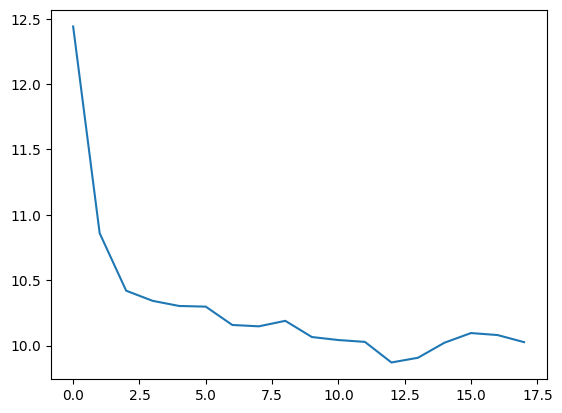

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/100
384/384 [==============================] - 5s 6ms/step - loss: 5.1533 - duration_loss: 0.0391 - instrument_loss: 0.3834 - pitch_loss: 3.1051 - step_loss: 4.9398
Epoch 2/100
384/384 [==============================] - 2s 5ms/step - loss: 5.0961 - duration_loss: 0.0358 - instrument_loss: 0.2783 - pitch_loss: 2.8823 - step_loss: 4.9023
Epoch 3/100
384/384 [==============================] - 2s 5ms/step - loss: 5.0672 - duration_loss: 0.0354 - instrument_loss: 0.2705 - pitch_loss: 2.8040 - step_loss: 4.8781
Epoch 4/100
384/384 [==============================] - 2s 5ms/step - loss: 5.0488 - duration_loss: 0.0342 - instrument_loss: 0.2660 - pitch_loss: 2.7505 - step_loss: 4.8638
Epoch 5/100
384/384 [==============================] - 2s 5ms/step - loss: 5.0329 - duration_loss: 0.0340 - instrument_loss: 0.2627 - pitch_loss: 2.7106 - step_loss: 4.8502
Epoch 6/100
384/384 [==============================] - 2s 5ms/step - loss: 5.0166 - duration_loss: 0.0339 - instrument_loss: 0.2604 - p

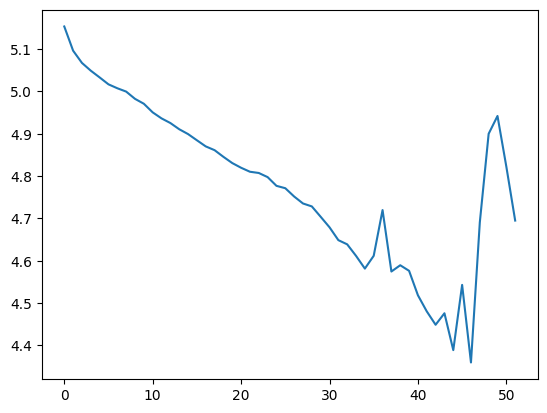

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/100
425/425 [==============================] - 6s 6ms/step - loss: 7.4979 - duration_loss: 0.2767 - instrument_loss: 0.9339 - pitch_loss: 5.3896 - step_loss: 6.9051
Epoch 2/100
425/425 [==============================] - 2s 6ms/step - loss: 7.5329 - duration_loss: 0.2670 - instrument_loss: 0.9465 - pitch_loss: 6.2664 - step_loss: 6.9053
Epoch 3/100
425/425 [==============================] - 2s 5ms/step - loss: 7.1399 - duration_loss: 0.2526 - instrument_loss: 0.7386 - pitch_loss: 4.8062 - step_loss: 6.6100
Epoch 4/100
425/425 [==============================] - 2s 6ms/step - loss: 7.1998 - duration_loss: 0.2501 - instrument_loss: 0.6803 - pitch_loss: 4.7906 - step_loss: 6.6761
Epoch 5/100
425/425 [==============================] - 2s 5ms/step - loss: 7.3664 - duration_loss: 0.2558 - instrument_loss: 0.7457 - pitch_loss: 5.5087 - step_loss: 6.7979
Epoch 6/100
425/425 [==============================] - 2s 6ms/step - loss: 7.0090 - duration_loss: 0.2504 - instrument_loss: 0.5908 - p

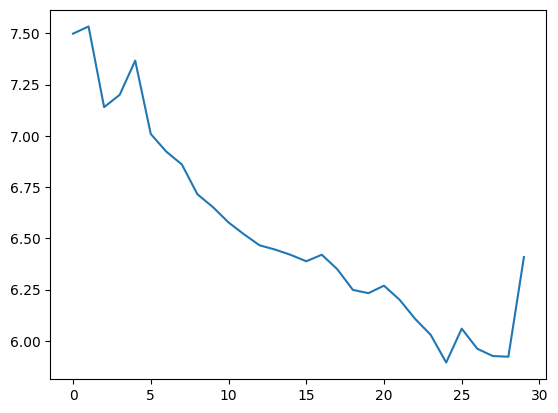

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/100
1507/1507 [==============================] - 19s 5ms/step - loss: 3.9578 - duration_loss: 0.1072 - instrument_loss: 0.8962 - pitch_loss: 3.7064 - step_loss: 3.6205
Epoch 2/100
1507/1507 [==============================] - 8s 5ms/step - loss: 3.7773 - duration_loss: 0.1052 - instrument_loss: 0.5588 - pitch_loss: 3.3938 - step_loss: 3.4744
Epoch 3/100
1507/1507 [==============================] - 8s 5ms/step - loss: 3.7228 - duration_loss: 0.1038 - instrument_loss: 0.5431 - pitch_loss: 3.3039 - step_loss: 3.4267
Epoch 4/100
1507/1507 [==============================] - 8s 5ms/step - loss: 3.6810 - duration_loss: 0.1049 - instrument_loss: 0.5361 - pitch_loss: 3.2414 - step_loss: 3.3872
Epoch 5/100
1507/1507 [==============================] - 8s 5ms/step - loss: 3.6842 - duration_loss: 0.1067 - instrument_loss: 0.5320 - pitch_loss: 3.2268 - step_loss: 3.3896
Epoch 6/100
1507/1507 [==============================] - 8s 5ms/step - loss: 3.4694 - duration_loss: 0.1034 - instrument_los

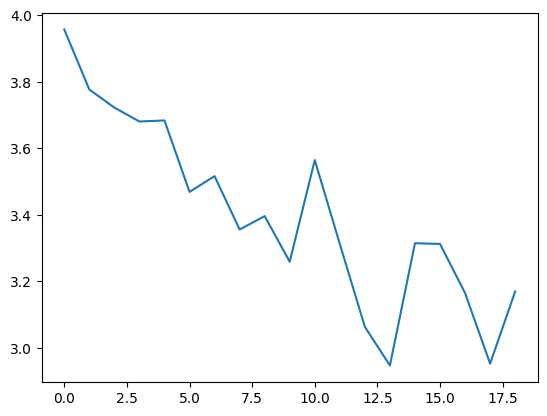

CPU times: user 11min 16s, sys: 1min 9s, total: 12min 25s
Wall time: 8min 32s


In [ ]:
%%time

for i in range(1, 5):
  midi_objects, top_instruments = load_midi_files_and_extract_instruments(filenames, i)
  all_notes = []
  for f in midi_objects:
    try:
      notes = midi_to_notes(f)
      all_notes.append(notes)
    except:
      continue

  all_notes = pd.concat(all_notes)
  train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
  notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
  seq_length = 50
  vocab_size = 128
  seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
  n_notes = len(all_notes)
  batch_size = 64
  buffer_size = n_notes - seq_length  # the number of items in the dataset
  train_ds = (seq_ds
              .shuffle(buffer_size)
              .batch(batch_size, drop_remainder=True)
              .cache()
              .prefetch(tf.data.experimental.AUTOTUNE))
  epochs = 100

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
  )
  model.save(f"model_{i}_instruments.keras")
  plt.plot(history.epoch, history.history['loss'], label='total loss')
  plt.show()

## Testiing models

In [ ]:
models = []
for i in range(1,5):
  models.append(tf.keras.models.load_model(f"model_{i}_instruments.keras"))

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x785a680b24d0>

In [1]:
def predict_process(model, temperature = 1.0, num_predictions=120):
  sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

  input_notes = (
      sample_notes[:seq_length] / np.array([vocab_size, vocab_size, 1, 1]))

  generated_notes = []
  prev_start = 0
  for _ in range(num_predictions):
    pitch, step, duration, instrument = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration, instrument)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

  generated_notes = pd.DataFrame(
      generated_notes, columns=(*key_order, 'start', 'end'))
  return generated_notes

In [ ]:
predicts = []
for m in range(len(models)):
  generated_notes = predict_process(models[m])
  out_file = f'output_{m}.mid'
  predicts.append(notes_to_midi(generated_notes, out_file=out_file))

1/1 [==============================] - 0s 19ms/step


In [ ]:
display_audio(predicts[0], seconds=120)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predicts[0].instruments

[Instrument(program=81, is_drum=False, name="")]

In [ ]:
display_audio(predicts[1], seconds=120)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predicts[1].instruments

[Instrument(program=38, is_drum=False, name=""),
 Instrument(program=81, is_drum=False, name="")]

In [ ]:
display_audio(predicts[2], seconds=120)


In [ ]:
predicts[2].instruments

[Instrument(program=38, is_drum=False, name=""),
 Instrument(program=81, is_drum=False, name="")]

In [ ]:
display_audio(predicts[3], seconds=120)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
predicts[3].instruments

[Instrument(program=38, is_drum=False, name=""),
 Instrument(program=81, is_drum=False, name="")]

## Test with real data

In [ ]:
filenames = get_file_pathes('/content/drive/MyDrive/palitech_5/2 kurs/диплом/data')

In [ ]:
print('Number of files:', len(filenames))

Number of files: 801


In [ ]:
%%time
for j in range(6, 9):
  filenames_actual = filenames[:j*100]
  for i in range(1, 4):
    midi_objects, top_instruments = load_midi_files_and_extract_instruments(filenames_actual, i)
    all_notes = []
    for f in midi_objects:
      try:
        notes = midi_to_notes(f)
        all_notes.append(notes)
      except:
        continue

    all_notes = pd.concat(all_notes)
    train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
    notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
    seq_length = 50
    vocab_size = 128
    seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
    n_notes = len(all_notes)
    batch_size = 64
    buffer_size = n_notes - seq_length  # the number of items in the dataset
    train_ds = (seq_ds
                .shuffle(buffer_size)
                .batch(batch_size, drop_remainder=True)
                .cache()
                .prefetch(tf.data.experimental.AUTOTUNE))
    epochs = 50

    history = model.fit(
        train_ds,
        epochs=epochs,
    )
    model.save(f"/content/drive/MyDrive/palitech_5/2 kurs/диплом/saved_models/model_{i}_instruments_{j}_units.keras")
    plt.plot(history.epoch, history.history['loss'], label='total loss')
    plt.show()

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 1/50
15265/15265 [==============================] - 213s 5ms/step - loss: 2.1184 - duration_loss: 0.1852 - instrument_loss: 0.0092 - pitch_loss: 3.1235 - step_loss: 1.7766
Epoch 2/50
15265/15265 [==============================] - 82s 5ms/step - loss: 2.1021 - duration_loss: 0.1832 - instrument_loss: 2.7111e-06 - pitch_loss: 2.9693 - step_loss: 1.7705
Epoch 3/50
15265/15265 [==============================] - 82s 5ms/step - loss: 2.0946 - duration_loss: 0.1831 - instrument_loss: 5.2042e-08 - pitch_loss: 2.8574 - step_loss: 1.7686
Epoch 4/50
15265/15265 [==============================] - 82s 5ms/step - loss: 2.0908 - duration_loss: 0.1830 - instrument_loss: 1.8394e-08 - pitch_loss: 2.7997 - step_loss: 1.7678
Epoch 5/50
15265/15265 [==============================] - 82s 5ms/step - loss: 2.0840 - duration_loss: 0.1823 - instrument_loss: 1.6240e-08 - pitch_loss: 2.7445 - step_loss: 1.7646
Epoch 6/50
15265/15265 [==============================] - 82s 5ms/step - loss: 2.0824 - duration_l

## Testing predictions


In [15]:

raw_notes = midi_to_notes(get_file_pathes('/content/drive/MyDrive/palitech_5/2 kurs/диплом/big_data')[100])

In [16]:
key_order = ['instrument', 'pitch', 'step', 'duration']

def get_models_pathes(top_directory, limit=800):
  notes = []

  filenames = []

  for root, dirs, files in os.walk(top_directory):
    for filename in files:
      if filename.endswith(".keras"):
        midi_path = os.path.join(root, filename)
        filenames.append(midi_path)
      if len(filenames) > limit:
        return filenames

  return filenames

In [19]:

models_filenames = get_models_pathes("/content/drive/MyDrive/palitech_5/2 kurs/диплом/saved_models")
models = []
for model in models_filenames:
  models.append(tf.keras.models.load_model(model))

In [20]:
seq_length = 50
vocab_size = 128
temperature = 2.0
num_predictions = 120
predicts = []
for m in range(len(models)):
  generated_notes = predict_process(models[m])
  out_file = f'output_{m}.mid'
  predicts.append(notes_to_midi(generated_notes, out_file=out_file))

1/1 [==============================] - 0s 23ms/step


In [23]:

display_audio(predicts[0], seconds=120)

Output hidden; open in https://colab.research.google.com to view.

In [24]:

display_audio(predicts[1], seconds=120)

In [ ]:

display_audio(predicts[2], seconds=120)

In [ ]:

display_audio(predicts[3], seconds=120)

In [ ]:

display_audio(predicts[4], seconds=120)

In [ ]:

display_audio(predicts[5], seconds=120)

In [ ]:

display_audio(predicts[6], seconds=120)

In [ ]:

display_audio(predicts[7], seconds=120)

In [ ]:

display_audio(predicts[8], seconds=120)

In [ ]:

display_audio(predicts[9], seconds=120)

In [ ]:

display_audio(predicts[10], seconds=120)

In [ ]:

display_audio(predicts[11], seconds=120)

In [ ]:

display_audio(predicts[0], seconds=120)

In [ ]:

display_audio(predicts[0], seconds=120)